In [63]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import cKDTree as KDTree
from scipy.stats import gaussian_kde
import sys
import time
import cv2

rng = default_rng(900)

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [4]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*1 # encoder dim
h_P_dim = 512*1 # decoder dim

# problem dimsions
nDrawnSamples = 23 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 7 # (truckX, truckY, truckYaw, truckX, trailerY, trailerYaw, steer)
dimGoal = 3
dimObs = 2
dimPredict = dim - 0 # predict truck (truckX, truckY, truckYaw, steer)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dimGoal + dimObs # steer sample, current pose (3D: x,y,yaw), goal (3D), dimObs (2D x 3)

z_dim = 3 # latent dim
X_dim = nDrawnSamples*dimPredict
c_dim = dataElements - X_dim # dimension of conditioning variable

roadWidth = 0.12
c = [0.5, 0.5]

In [66]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:

            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))

            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/networks/intersect_23.pt', map_location=torch.device(DEVICE))

In [6]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/mapC_data_10kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,4,5,6,10,11,12,13,14]) # disregard init

_, pathsIdx = np.unique(rawdata[:,dim:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data)
for ci, i in enumerate(validPlansIdx[:-1].reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)
        
        seqstates = rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim)
        if np.where(np.abs(seqstates[0, 4:(nPreviousStates + nDrawnSamples)*dim:dim]) < 3e-2)[0].shape[0] >= (nDrawnSamples + nPreviousStates) // 1.2:
            continue

        tempdata = np.vstack((tempdata, np.append(seqstates, rawdata[i, dim:].reshape(1, dimGoal+dimObs), axis=1))) 

        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

data = data[1:]

rng.shuffle(data) # shuffle data (otherwise the data is sorted by obstacles/the map)

pathData = np.copy(data[:, :-dimObs])
obsData = np.copy(data[:, -dimObs:])

numEntries = pathData.shape[0]
print(numEntries)

14488


In [7]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

x = pathData[:, dim * nPreviousStates:-dim+1:dim]
y = pathData[:, 1 + dim * nPreviousStates:-dim+2:dim]
yaw = pathData[:, 2 + dim * nPreviousStates:-dim+3:dim]
steer = pathData[:, 4 + dim * nPreviousStates:-dim+5:dim]
tx = pathData[:, 5 + dim * nPreviousStates:-dim+6:dim]
ty = pathData[:, 6 + dim * nPreviousStates:-dim+6:dim]
tyaw = pathData[:, 3 + dim * nPreviousStates:-dim+4:dim]

X = np.zeros(shape=(numEntries, X_dim))
X[:, ::dimPredict] = x
X[:, 1::dimPredict] = y
X[:, 2::dimPredict] = yaw
X[:, 3::dimPredict] = steer
X[:, 4::dimPredict] = ty
X[:, 5::dimPredict] = tx
X[:, 6::dimPredict] = tyaw

X_train = X[:numTrain]
X_test = X[numTrain:numEntries]

numTest = X_test.shape[0]

print(X_train.shape)

(11590, 161)


In [8]:
# generate conditioning variable

nextStates = pathData[:, nPreviousStates*dim:-dimGoal]

prevStatesConditions = pathData[:, :nPreviousStates * dim]
goalStateCondition = pathData[:, -dimGoal:]

conditionsOcc = np.copy(obsData)

cs = np.concatenate((prevStatesConditions, goalStateCondition, conditionsOcc), axis=1)

c_dim = cs.shape[1]
c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(14488, 12)


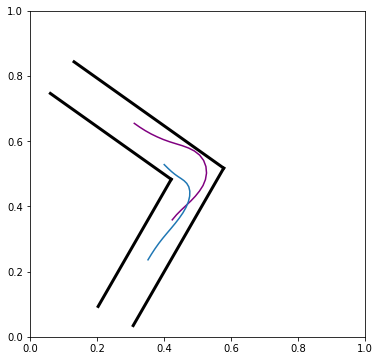

In [9]:
# Visualize data sample

i = np.random.randint(1,numEntries)

alpha1 = obsData[i, 0]
alpha2 = obsData[i, 1]
c = [0.5, 0.5]

a = c[0] + 0.5 * np.array([np.cos(alpha1), np.sin(alpha1)]) # line segment 1 end point
b = c[1] + 0.5 * np.array([np.cos(alpha2), np.sin(alpha2)]) # line segment 2 end point

sign = np.where(alpha1 < alpha2, 1, -1)
k = (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))

lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k
scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k

plt.figure(figsize=(6,6))
plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
plt.plot(pathData[i, :-dim:dim], pathData[i, 1:-dim:dim], color='purple')
plt.plot(pathData[i, 5:-dim:dim], pathData[i, 6:-dim:dim], color='C0')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [10]:
def dist2linesegment(p, a, b): # p: point, a: line end 1, b: line ned 2
    """
    # from https://stackoverflow.com/a/58781995

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """

    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

In [64]:
# define planning problem
class MyGoal(ob.Goal):
    def __init__(self, si, goal):
        super(MyGoal, self).__init__(si)
        self.goal = goal

    def isSatisfied(self, state):
        return np.linalg.norm(self.goal - np.array([state[0], state[1], (state[2] + np.pi) % (2 * np.pi) - np.pi])) < 0.03


def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


class MyNNStateSampler(ob.StateSampler):
    def __init__(self, space):
         super(MyNNStateSampler, self).__init__(space)
         self.name_ = "my sampler"
         self.bounds = space.getBounds()

    def sampleUniform(self, state):
        global sampledStates

        if np.random.uniform() < pStates:
            # Use a CVAE state:
            sampleInd = np.random.randint(low=0, high=numSamples-1)
            stateInd = np.random.randint(low=0, high=nDrawnSamples)
            rndState = predictedStates[sampleInd, stateInd*dim:(stateInd+1)*dim]
        else:

            rndState = [np.random.uniform(low=self.bounds.low[0], high=self.bounds.high[0]),
                        np.random.uniform(low=self.bounds.low[1], high=self.bounds.high[1]),
                        np.random.uniform(low=-np.pi, high=np.pi),
                        np.random.uniform(low=-np.pi, high=np.pi)]

        state[0] = float(rndState[0])
        state[1] = float(rndState[1])
        state[2] = float(rndState[2])
        state[3] = float(rndState[3])


        sampledStates = np.vstack((sampledStates, np.array([[state[0],
                                                         state[1], 
                                                         state[2],
                                                         state[3]]])))


class MyNNControlSampler(oc.ControlSampler):
    def __init__(self, cspace):
        super(MyNNControlSampler, self).__init__(cspace)
        self.name = "my sampler"
        self.cbounds = cspace.getBounds()
        
    def sampleNext(self, control, previous, state):
        global nDrawnCtrl
        nDrawnCtrl += 1

        trailerX = state[0] - b1 * np.cos(state[2]) - 1.0 * b2 * np.cos(state[3])
        trailerY = state[1] - b1 * np.sin(state[2]) - 1.0 * b2 * np.sin(state[3])
        currentState = np.array([state[0], state[1], state[2], state[3], previous[0], trailerX, trailerY])
        stateNorm = np.linalg.norm(predictedStates.reshape(numSamples, nDrawnSamples, dim) - currentState, axis=2)

        # if np.random.uniform() < pControl and np.min(stateNorm) < 0.5:
        #     # Use a CVAE control input
        #     # Use the control input from the predicted states/inputs that are nearest (Eucl.) the current state

        #     nearestInd = np.argwhere(stateNorm == np.min(stateNorm)).reshape(-1)
        #     nearestState = predictedStates[nearestInd[0], nearestInd[1]*dim:(nearestInd[1]+1)*dim]
        #     delta = nearestState[3]
            
        #     control[0] = float(delta)

        # else:
        #     control[0] = float(np.random.uniform(low=self.cbounds.low[0], high=self.cbounds.high[0]))

        if np.random.uniform() < pControl:
            # Use a CVAE control input

            condition = torch.from_numpy(np.repeat([np.concatenate((currentState, goal, obsData[planIdx, :]))], numSamples, axis=0)).float().to(DEVICE)
            y = network(torch.randn(numSamples, z_dim).to(DEVICE), condition, encode=False).cpu().detach().numpy()

            kde = gaussian_kde(y[:, 3])
            delta = steerAngles[np.argmax(kde.pdf(steerAngles))]

            # t = np.tile(np.arange(nDrawnSamples), reps=(numSamples, 1)) * 0.2
            # plt.scatter(t, y[:, 3::dimPredict], alpha=0.02, color='C2', label='CVA predicted control') # Predict
            # plt.show()
            # print(delta)

            control[0] = float(delta)

        else:
            control[0] = float(np.random.uniform(low=self.cbounds.low[0], high=self.cbounds.high[0]))


def allocNNStateSampler(space):
    return MyNNStateSampler(space)


def allocNNControlSampler(cspace):
    return MyNNControlSampler(cspace)


def isRV4Valid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    pTruck = np.array([state[0], state[1]])

    xTrailer = state[0] - b1 * np.cos(state[2]) - np.linspace(0, b2, 6) * np.cos(state[3])
    yTrailer = state[1] - b1 * np.sin(state[2]) - np.linspace(0, b2, 6) * np.sin(state[3])
    pTrailer = np.array([xTrailer, yTrailer]).T

    l1distTruck = dist2linesegment(pTruck, a=l1a, b=l2a)
    l2distTruck = dist2linesegment(pTruck, a=l1b, b=l2b)

    l1distTrailer = dist2linesegment(pTrailer, a=np.tile(l1a, reps=(pTrailer.shape[0], 1)), b=np.tile(l2a, reps=(pTrailer.shape[0], 1)))
    l2distTrailer = dist2linesegment(pTrailer, a=np.tile(l1b, reps=(pTrailer.shape[0], 1)), b=np.tile(l2b, reps=(pTrailer.shape[0], 1)))

    if spaceInformation.satisfiesBounds(state):
        return np.where((l1distTruck <= roadWidth / 2) | (l2distTruck <= roadWidth / 2))[0].shape[0] == 1 and np.where((l1distTrailer <= roadWidth / 2) | (l2distTrailer <= roadWidth / 2))[0].shape[0] == pTrailer.shape[0]


def propagate(start, control, duration, state):

    beta = np.arctan(np.tan(control[0]) * a12 / (a11 + a12))

    state[0] = start[0] + v * np.cos(start[2] + beta) * duration
    state[1] = start[1] + v * np.sin(start[2] + beta) * duration
    state[2] = start[2] + v * np.sin(beta) / a12 * duration
    state[3] = start[3] + (v * np.sin(start[2] - start[3]) / (b2 + a21) - v * (b1 - a12) * np.cos(start[2] - start[3]) * np.sin(beta) / (a12 * (b2 + a21))) * duration


def problemDef():
    # construct the state space we are planning in
    space = ob.RealVectorStateSpace(4)

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(4)
    bounds.setLow(0, 0.001)
    bounds.setLow(1, 0.001)
    bounds.setLow(2, -2 * np.pi)
    bounds.setLow(3, -2 * np.pi)
    bounds.setHigh(0, 0.999)
    bounds.setHigh(1, 0.999)
    bounds.setHigh(2, 2 * np.pi)
    bounds.setHigh(3, 2 * np.pi)
    space.setBounds(bounds)

    # create a control space
    cspace = oc.RealVectorControlSpace(space, 1)

    # set the bounds for the control space
    cbounds = ob.RealVectorBounds(1)
    cbounds.setLow(-0.65)
    cbounds.setHigh(0.65)
    cspace.setBounds(cbounds)

    ss = oc.SimpleSetup(cspace)
    ss.setStatePropagator(oc.StatePropagatorFn(propagate))
    # set NN samplers
    cspace.setControlSamplerAllocator(oc.ControlSamplerAllocator(allocNNControlSampler))
    space.setStateSamplerAllocator(ob.StateSamplerAllocator(allocNNStateSampler))

    si = ss.getSpaceInformation()

    si.setPropagationStepSize(.2)
    si.setMinMaxControlDuration(1, 1)
    planner = oc.RRT(si)

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isRV4Valid, ss.getSpaceInformation())))

    planner = oc.RRT(si)
    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))

    return ss

def plan(planObj, initState, goalState):

    space = ob.RealVectorStateSpace(4)

    start = ob.State(space)
    start[0] = initState[0] # truck x
    start[1] = initState[1] # truck y
    start[2] = initState[2] # truck yaw
    start[3] = initState[3] # trailer yaw

    si = planObj.getSpaceInformation()
    planObj.setStartState(start)
    planObj.setGoal(MyGoal(si, goalState))

    timeTerminationCondition = ob.timedPlannerTerminationCondition(2000.)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 45337 states
Info:    Solution found in 835.921259 seconds


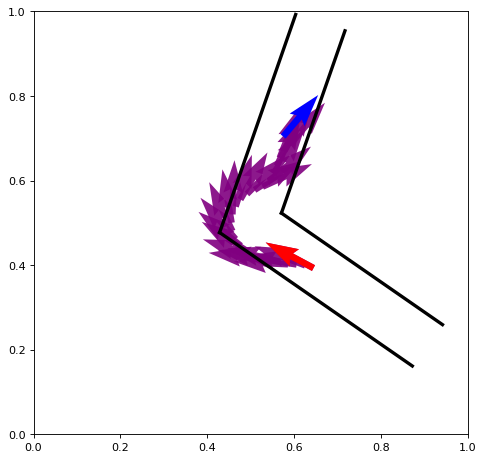

Info:    RRT: Starting planning with 1 states already in datastructure


KeyboardInterrupt: 

In [67]:
# compare performance of planning w/ and w/out the learned distributions

numSamples = 400 # number of drawn CVAE samples (/)per time step)
nMaps = 1 # number of test maps
nTestsPerMap = 5 # number of tests per test map

pStates = 0.6 # likelihood which to sample from NN state samples
pControl = 0.6 # likelihood which to sample from NN control samples

v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
Lt  = 0.20 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2
roadWidth = 0.12

maxSteer = np.max(data[:, 3::dim])
minSteer = np.min(data[:, 3::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=200)

pdef = problemDef()
nSampledStates = np.zeros(shape=(nMaps,nTestsPerMap))

#planIdxs = np.random.choice(np.arange(numTrain, numEntries-1), nMaps, replace=False)

plotPaths = True
for i, planIdx in enumerate(planIdxs):
    alpha1 = obsData[planIdx, 0]
    alpha2 = obsData[planIdx, 1]
    c = np.array([0.5, 0.5])

    a = c[0] + 0.5 * np.array([np.cos(alpha1), np.sin(alpha1)]) # line segment 1 end point
    b = c[1] + 0.5 * np.array([np.cos(alpha2), np.sin(alpha2)]) # line segment 2 end point

    l1a = a.reshape(1,2)
    l2a = c.reshape(1,2)
    l1b = b.reshape(1,2)
    l2b = np.copy(l2a)

    sign = np.where(alpha1 < alpha2, 1, -1)
    k = (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))

    lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
    lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k
    scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
    scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k

    for j in range(nTestsPerMap):

        sampledStates = np.zeros(shape=(1, 4))

        start = data[planIdx, :dim]
        trueGoal = data[planIdx, -dimObs-dimGoal:-dimObs] # x, y, yaw ('true' goal)
        goal = data[planIdx, -dimObs-dimGoal-dim:-dimObs-dim] # goal as the final state in true predicted states (intermediate goal)

        condition = torch.from_numpy(np.repeat([np.concatenate((start, goal, obsData[planIdx, :]))], numSamples, axis=0)).float().to(DEVICE)
        predictedStates = network(torch.randn(numSamples, z_dim).to(DEVICE), condition, encode=False).cpu().detach().numpy()

        pdef.clear()
        nDrawnCtrl = 0
        plan(pdef, initState=start, goalState=goal)
        
        if pdef.getProblemDefinition().hasExactSolution():

            sol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
            nSampledStates[i, j] = sampledStates.shape[0] - 1

            if plotPaths:
                fig1 = plt.figure(figsize=(7,7), dpi=80)
                plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
                plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
                plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
                plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
                plt.quiver(sol[:, 0], sol[:, 1], np.cos(sol[:,2]), np.sin(sol[:,2]), color="purple", scale=8.0, width=0.015, alpha=0.9)
                plt.quiver(start[0], start[1], np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
                plt.quiver(goal[0], goal[1], np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
                plt.xlim(0, 1)
                plt.ylim(0, 1)
                plt.show()


fig2 = plt.figure(figsize=(7,7), dpi=80)
plt.scatter(predictedStates[:,::dim], predictedStates[:,1::dim], color='green', s=70, alpha=0.01, label='CVA predicted ($p_x$, $p_y$) states') # nn samples
plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
plt.xlabel('$p_x [-]$', fontsize=14)
plt.ylabel('$p_y [-]$', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    if not lh.get_alpha() is None:
        lh.set_alpha(1)
plt.show()

In [68]:
print('Mean num sampled states/map: {}, std: {}'.format(np.mean(nSampledStates, axis=1), np.std(nSampledStates, axis=1)))
# print('Mean num sampled states: {}, std: {}'.format(np.mean(nSampledStates), np.std(nSampledStates)))
print(nSampledStates)

#nSamplesNoNN = nSampledStates
#nSamplesNNStates = nSampledStates
#SamplesNNStatesControl = nSampledStates

# [17443.]
# 
# 


Mean num sampled states/map: [40167.6], std: [80335.2]
[[200838.      0.      0.      0.      0.]]


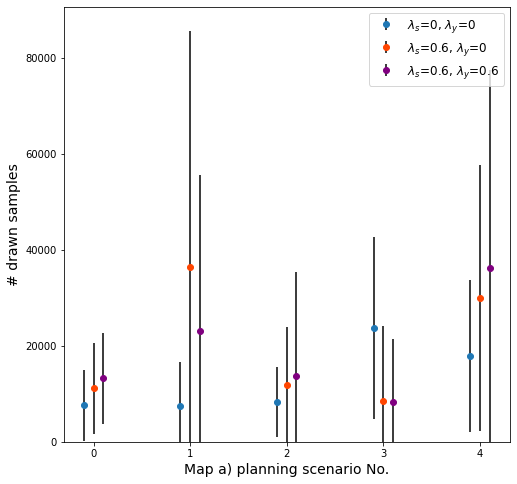

In [44]:
# create plots for nSampledStates with varying pStates and pControl

fig = plt.figure(figsize=(8,8))
plt.errorbar(np.arange(nMaps) - 0.1, np.mean(nSamplesNoNN, axis=1), np.std(nSamplesNoNN, axis=1), color='C0', fmt='o', ecolor='k', label='$\lambda_s$=0, $\lambda_y$=0')
plt.errorbar(np.arange(nMaps), np.mean(nSamplesNNStates, axis=1), np.std(nSamplesNNStates, axis=1), color='orangered', fmt='o', ecolor='k', label='$\lambda_s$=0.6, $\lambda_y$=0')
plt.errorbar(np.arange(nMaps) + 0.1, np.mean(nSamplesNNStatesControl, axis=1), np.std(nSamplesNNStatesControl, axis=1), color='purple', fmt='o', ecolor='k', label='$\lambda_s$=0.6, $\lambda_y$=0.6')
plt.xlabel('Map a) planning scenario No.', fontsize=14)
plt.ylabel('# drawn samples', fontsize=14)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.show()

In [118]:
# animate explored states
uniqueExploredStates = exploredStates[np.sort(np.unique(exploredStates, axis=0, return_index=True)[1])]

print(exploredStates.shape)
print(uniqueExploredStates.shape)

# dist = np.linalg.norm(np.diff(uniqueExploredStates[:,:2], axis=0), axis=1)
# plotIdx = np.where(np.abs(dist - 0.1) < 0.1)[0][::6]
# print(plotIdx.shape)

# def update_plot(i):
#     scat = plt.scatter(x[plotIdx[i]:plotIdx[i+1]] * gridSize, y[plotIdx[i]:plotIdx[i+1]] * gridSize, color='C0', s=10, alpha=3.1/np.sqrt(plotIdx.shape[0]))
#     return scat

# numframes = plotIdx.shape[0] - 1SE

# x, y = uniqueExploredStates[:,0], uniqueExploredStates[:,1]

# fig = plt.figure(figsize=(4,4))
# plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
# plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
# plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
# plt.xlim([0, gridSize])
# plt.ylim([0, gridSize])
# plt.xlabel('x', fontsize=12)
# plt.ylabel('y', fontsize=12)

# ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes))

# print("saving animation")                            
# ani.save('animation.mp4', fps=20)

(66867, 4)
(66867, 4)
